## import packages

In [1]:
import collections
from datetime import datetime
from IPython.display import clear_output, display, HTML
import itertools
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
from pathlib import Path
import pickle
import scipy
# import seaborn as sns
import sklearn
from sklearn.decomposition import PCA
import sys
from scipy.ndimage import gaussian_filter1d
from wfOpto import *
import imageio
from IPython.display import HTML


In [2]:
import pytoolsAL as ptAL

pytoolsAL: Modules missing.  Not loading image.  Message: cannot import name 'geometry' from 'skimage._shared' (c:\Users\nadia\anaconda3\envs\steinmetzlab\Lib\site-packages\skimage\_shared\__init__.py)
It seems that scikit-image has not been built correctly.

Your install of scikit-image appears to be broken.
Try re-installing the package following the instructions at:
https://scikit-image.org/docs/stable/user_guide/install.html
pytoolsAL: Modules missing.  Not loading neuropixels.  Message: No module named 'slidingRP'
pytoolsAL: Modules missing.  Not loading plotting.  Message: No module named 'pandas'


In [3]:
#work
plt.style.use(r'C:\Users\nadia\Documents\GitHub\steinmetzlab\ALpres.mplstyle')

In [3]:
#personal
plt.style.use(r'C:\GitHub\steinmetzlab\ALpres.mplstyle')

## Power:Inactivation figs

### import

In [4]:
dataOp312=wfOpto(Path(r'Y:\Subjects\AB_0026\2024-03-12\1'))

### fig funcs

#### with deconv

In [110]:
def powerDep3Pow(ax,data,mouse,day,galvoX,galvoY,y,x,ylim=[-30,30],powers=np.array([0.2,1.7,3]),n_samples=650):
    '''
    generate a plot of activity traces for 3 powers
    average over trials
    '''
    colors=['deepskyblue','dodgerblue','mediumblue']
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y,x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    for c,iP in enumerate(pxPowers):
        plt.plot(timestamps, np.mean(iP, axis=0),linewidth=2,color=colors[c])
        plt.fill_between(timestamps, \
                np.mean(iP, axis=0)-scipy.stats.sem(iP,axis=0),\
                np.mean(iP,axis=0)+scipy.stats.sem(iP,axis=0), color=colors[c], label='_nolegend_',alpha=.3,linewidth=0)
    powers_corrected=[round(i/2.777777778,2) for i in powers]
    plt.legend(powers_corrected, loc='upper right',bbox_to_anchor=(1.2,1))
    plt.xlabel('Time (ms)',fontsize=8)
    plt.ylabel('Brain Activity ($\Delta F$)',fontsize=8)
    plt.title(f'Subject: {mouse} Day: {day}',fontsize=10)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.axvspan(0,100,color='gray',alpha=.2,lw=0,label='_nolegend_')
    plt.ylim(ylim)
    

<>:37: SyntaxWarning: invalid escape sequence '\D'
<>:37: SyntaxWarning: invalid escape sequence '\D'
C:\Users\nadia\AppData\Local\Temp\ipykernel_13884\431764188.py:37: SyntaxWarning: invalid escape sequence '\D'
  plt.ylabel('Brain Activity ($\Delta F$)',fontsize=8)


In [115]:
def powerDepAllPow(ax,data,mouse,day,galvoX,galvoY,y,x,ylim=[-30,30],n_samples=650):
    '''
    generate a plot with time traces for all of the powers in the experiment
    averaged over trials
    '''
    powers = np.unique(data.laserPowers)
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000
    colors=plt.cm.Blues(np.linspace(0,1,len(powers)))

    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    for i,iP in enumerate(pxPowers):
        plt.plot(timestamps, np.mean(iP, axis=0),color=colors[i],lw=1.5,label=powers[i])
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    plt.xlabel('Time (ms)',fontsize=8)
    plt.title(f'Subject: {mouse} Day: {day}',fontsize=10)
    plt.ylim(ylim)
    plt.legend(ncols=2,fontsize=10,markerscale=0)

In [112]:
def powerQuant(ax,data,galvoX,galvoY,y,x,n_samples=650):
    '''
    plot the peak inactivation (90ms) against the corresponding power 
    average over trials
    '''
    powers = np.unique(data.laserPowers)
    powers_corrected=[round(i/2.777777778,2) for i in powers]
    pxPowers = []
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse!!
    galvoXTr=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYTr=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXTr,galvoYTr)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    timeMean = np.mean(time90, axis=1)
    plt.plot(powers,timeMean,'-o',c='k',lw=2)
    plt.errorbar(powers,timeMean,yerr=.8,c='k')
    plt.scatter(powers,timeMean)
    ax.set_xticklabels(powers_corrected)
    plt.xlabel("Laser powers (mW)",fontsize=8)
    plt.title("Inactivation at Peak (90 ms)",fontsize=10)

#### with df/f

### panels, and specify day

In [113]:
data=dataOp312
mouse="AB_0032"
date="3/12"
y=410
x=170
galvoX=0
galvoY=2.5
ylim=[-60,80]
powers=[.2,1.5,3.2]

C:\Users\nadia\AppData\Local\Temp\ipykernel_13884\1083144296.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(powers_corrected)


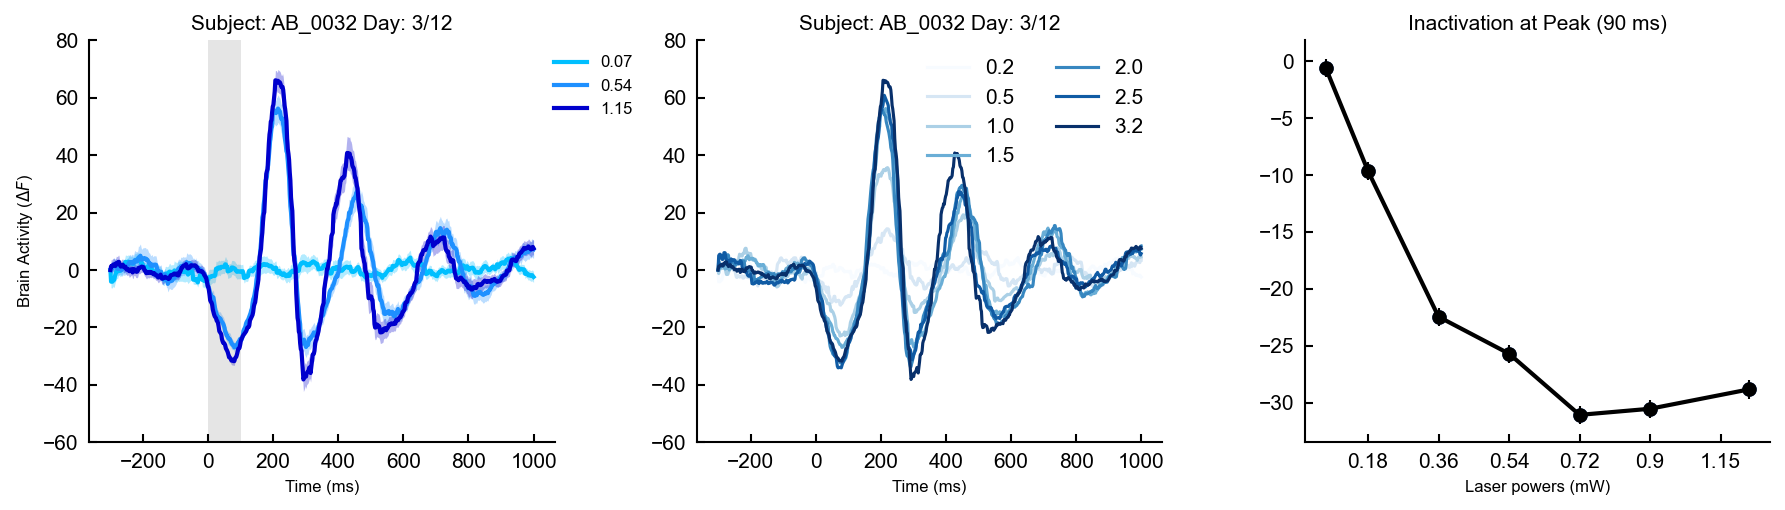

In [116]:
f = plt.figure(figsize=(12, 3.5))
gs = mpl.gridspec.GridSpec(1, 3)

ax = plt.subplot(gs[0])
powerDep3Pow(ax,data=dataOp312,galvoX=galvoX,galvoY=galvoY,ylim=ylim,y=y,x=x,powers=powers,mouse=mouse,day=date)

ax = plt.subplot(gs[1])
powerDepAllPow(ax,data=dataOp312,galvoX=galvoX,galvoY=galvoY,ylim=ylim,y=y,x=x,mouse=mouse,day=date)

ax = plt.subplot(gs[2])
powerQuant(ax,data=dataOp312,galvoX=galvoX,galvoY=galvoY,y=y,x=x)

f.tight_layout()

In [ ]:
f.savefig(f'C:\GitHub\steinmetzlab\wf + opto\figs\control\{mouse}_{date}')

### overlaying multiple days/preparations

In [15]:
def powerQuantReturn(data,y,x,galvoY,galvoX):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    #changes per mouse!!
    galvoXtrs=np.argwhere(data.galvoX==galvoX).ravel()
    galvoYtrs=np.argwhere(data.galvoY==galvoY).ravel()
    loc=np.intersect1d(galvoXtrs,galvoYtrs)

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        pwTrs = np.argwhere(data.laserPowers == power).ravel()
        theseTrs=np.intersect1d(pwTrs,loc)
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    return(np.mean(time90, axis=1))

In [16]:
quant312=powerQuantReturn(data=dataOp312,y=360,x=160,galvoX=0,galvoY=2.5)
quant621=powerQuantReturn(data=dataOp621,y=410,x=170,galvoX=0,galvoY=4)
days=[quant312,quant425,quant621]

NameError: name 'dataOp312' is not defined

In [17]:
quant425=powerQuantReturn(data=dataOp425,y=410,x=170,galvoX=0,galvoY=3.3)


accross days

In [18]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp425.laserPowers)
colors=['deepskyblue', 'royalblue', 'darkblue']
labels=['3/12', '4/25', '6/21']
for i,day in enumerate(days):
    plt.plot(powers[0:len(day)],day,'-o',c=colors[i],lw=1,markersize=2)

    plt.errorbar(powers[0:len(day)],day,yerr=1,c=colors[i],label='_nolegend_')

    plt.scatter(powers[0:len(day)],day,label='_nolegend_',s=.5)

plt.legend(labels,loc='upper right',fontsize=5)
plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel('Brain Activity df/f',fontsize=7)
plt.title("Inactivation at Peak Across Days",fontsize=8)

NameError: name 'days' is not defined

<Figure size 800x600 with 0 Axes>

across preps

In [19]:
def powerQuantReturn2(data,y,x):
    powers = np.unique(data.laserPowers)
    pxPowers = []
    n_samples = 650
    timestamps = np.linspace(-0.3, 1, n_samples)*1000

    pixel_ix = np.ravel_multi_index((y, x), (data.py, data.px))
    for iP, power in enumerate(powers):
        theseTrs = np.argwhere(data.laserPowers == power).ravel()
        onTimes = data.laserOn[theseTrs]
        trs = [np.linspace(-.3+on, 1+on, n_samples) for on in onTimes]
        trs = np.squeeze(np.array(trs))
        
        thisPower = []
        for iT, tr in enumerate(trs):
            wf = data.tToWFManual(tr)
            dwf = [np.diff(i, prepend=i[0]) for i in wf.T]
            dwf = np.array(dwf)
            mov = data.svdSpat[pixel_ix] @ dwf
            thisPower.append(mov)
        thisPower = np.array(thisPower)
        pxPowers.append(thisPower)

    pixelInterp = scipy.interpolate.interp1d(timestamps, pxPowers, axis=2, fill_value='extrapolate')

    time90 = pixelInterp(90)

    return(np.mean(time90, axis=1))

In [46]:
quant816_ZYE=powerQuantReturn2(data=dataOp816_ZYE,y=300,x=200)
quant822_ZYE=powerQuantReturn2(data=dataOp822_ZYE,y=300,x=200)
quant621_AL=powerQuantReturn2(data=dataOp621_AL,y=420,x=120)
quant622_AL=powerQuantReturn2(data=dataOp622_AL,y=420,x=120)
mice=[quant816_ZYE,quant822_ZYE,quant425,quant621_AL,quant622_AL]

Text(0.5, 1.0, 'Inactivation at Peak Across Preps')

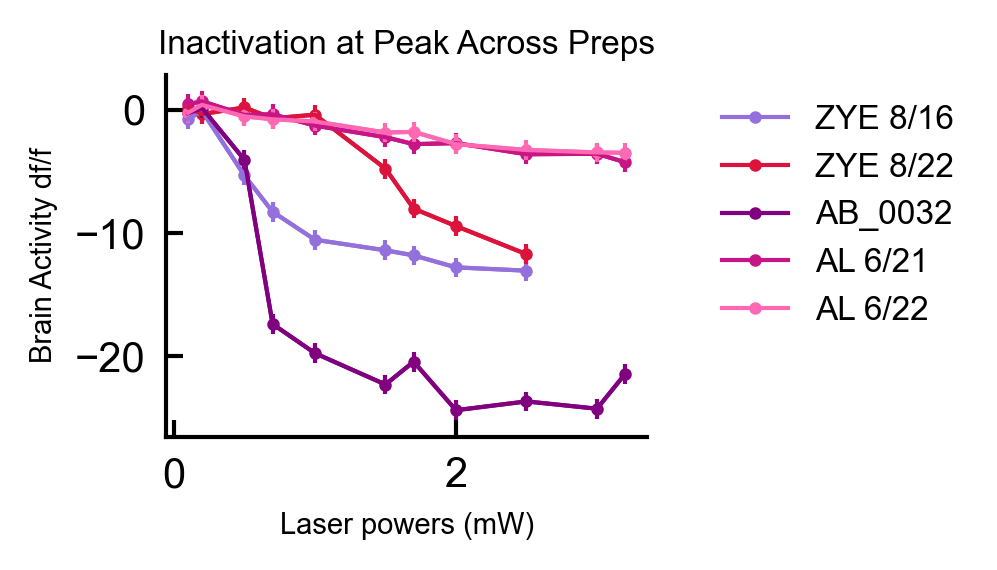

In [47]:
f = plt.figure(figsize=(4/1.5, 3/1.5), dpi=300)
powers=np.unique(dataOp425.laserPowers)
colors=['mediumpurple', 'crimson', 'purple','mediumvioletred','hotpink']
labels=['ZYE 8/16','ZYE 8/22','AB_0032', "AL 6/21","AL 6/22"]
for i,mouse in enumerate(mice):
    plt.plot(powers[0:len(mouse)],mouse,'-o',c=colors[i],lw=1,markersize=2)

    plt.errorbar(powers[0:len(mouse)],mouse,yerr=.8,c=colors[i],label='_nolegend_')

    plt.scatter(powers[0:len(mouse)],mouse,label='_nolegend_',c=colors[i],s=.5)

plt.legend(labels,loc='upper right',bbox_to_anchor=(1.7,1))
plt.xlabel("Laser powers (mW)",fontsize=7)
plt.ylabel("Brain Activity df/f",fontsize=7)
plt.title("Inactivation at Peak Across Preps",fontsize=8)

### function to show brain

useful for testing what pixel/ROI to chose

In [20]:
def brain(data,galvoX=0,galvoY=0,power=2,frame=100,n_samples=300,start=0,end=1,X=150,Y=350):
    '''
    image of the brain
    can change where you stim (galvoX, galvoY),
        power you stimulate with, frame you take as peak,
        and samples in trial
        frame which you take your img from, just a single one
    '''
    pows = np.argwhere(data.laserPowers==power).ravel()
    galvoYTrs=np.argwhere(data.galvoY==galvoY)
    galvoXTrs=np.argwhere(data.galvoX==galvoX)
    loc=np.intersect1d(galvoXTrs,galvoYTrs)
    theseTrs=np.intersect1d(loc,pows)

    trial_time_all = [np.linspace(i-start, i+end, n_samples)*1000 for i in theseTrs]
    trial_activity_all = data.tToWf(trial_time_all)
    trial_activity_all = np.mean(trial_activity_all, axis=0)
    
    dwf = [np.diff(i, prepend=i[0]) for i in trial_activity_all]
    dwf = np.array(dwf)
    
    spatial = data.svdSpatFull.reshape(560*560, -1)
    videoAvg = spatial @ dwf.T
    videoAvg = videoAvg.reshape(560,560,-1)
    
    plt.imshow(videoAvg[:,:,frame], cmap='bwr',clim = np.percentile(videoAvg, (2, 99.9)))
    plt.scatter(X,Y,color='orange',s=15)